In [1]:
import xlrd
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/KPMG_VI_New_raw_data_update_final.xlsx


In [2]:
file_name = '../data/KPMG_VI_New_raw_data_update_final.xlsx'
print(pd.ExcelFile(file_name).sheet_names)

['Title Sheet', 'Transactions', 'NewCustomerList', 'CustomerDemographic', 'CustomerAddress']


In [3]:
demo_df = pd.read_excel(file_name, header=1, sheet_name='CustomerDemographic', index_col=0)
demo_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
customer_id,,,,,,,,,,,,
1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [4]:
demo_df = demo_df.drop(['first_name', 'last_name', 'default', 'job_title'], axis=1)
demo_df['gender'].replace(['F', 'Femal'], 'Female', inplace=True)
demo_df['gender'].replace('M', 'Male', inplace=True)
demo_df['gender'].replace('U', 'Unknown', inplace=True)
demo_df['deceased_indicator'].replace(['N'], 0, inplace=True)
demo_df['deceased_indicator'].replace(['Y'], 1, inplace=True)
demo_df['owns_car'].replace('Yes', 1, inplace=True)
demo_df['owns_car'].replace('No', 0, inplace=True)
demo_df = demo_df[demo_df['DOB'] != demo_df.DOB.min()]
demo_df[demo_df['deceased_indicator'] == 0]
demo_df = demo_df.drop(['deceased_indicator'], axis=1)
demo_df_clean = demo_df.dropna()
demo_df_clean.head()

,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure
customer_id,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,1,11.0
2,Male,81,1980-12-16,Financial Services,Mass Customer,1,16.0
3,Male,61,1954-01-20,Property,Mass Customer,1,15.0
4,Male,33,1961-10-03,IT,Mass Customer,0,7.0
6,Male,35,1966-09-16,Retail,High Net Worth,1,13.0


In [5]:
demo_df_clean['age'] = (dt.datetime.now() - demo_df_clean['DOB']) / np.timedelta64(1, 'Y')
demo_df_clean['age_class'] = ((round(demo_df_clean['age'] / 10)) * 10).astype(int)
demo_df_clean.head()

<ipython-input-5-ee226aa8ec16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_df_clean['age'] = (dt.datetime.now() - demo_df_clean['DOB']) / np.timedelta64(1, 'Y')
<ipython-input-5-ee226aa8ec16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_df_clean['age_class'] = ((round(demo_df_clean['age'] / 10)) * 10).astype(int)


,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_class
customer_id,,,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,1,11.0,66.878850,70
2,Male,81,1980-12-16,Financial Services,Mass Customer,1,16.0,39.699648,40
3,Male,61,1954-01-20,Property,Mass Customer,1,15.0,66.605060,70
4,Male,33,1961-10-03,IT,Mass Customer,0,7.0,58.903327,60
6,Male,35,1966-09-16,Retail,High Net Worth,1,13.0,53.950454,50


In [6]:
addr_df = pd.read_excel(file_name, header=1, sheet_name='CustomerAddress', index_col=0)
addr_df.head()

,address,postcode,state,country,property_valuation
customer_id,,,,,
1,060 Morning Avenue,2016,New South Wales,Australia,10
2,6 Meadow Vale Court,2153,New South Wales,Australia,10
4,0 Holy Cross Court,4211,QLD,Australia,9
5,17979 Del Mar Point,2448,New South Wales,Australia,4
6,9 Oakridge Court,3216,VIC,Australia,9


In [7]:
addr_df['state'].replace('New South Wales', 'NSW', inplace=True)
addr_df['state'].replace('Victoria', 'VIC', inplace=True)
addr_df_clean = addr_df.dropna()
addr_df_clean.head()

,address,postcode,state,country,property_valuation
customer_id,,,,,
1,060 Morning Avenue,2016,NSW,Australia,10
2,6 Meadow Vale Court,2153,NSW,Australia,10
4,0 Holy Cross Court,4211,QLD,Australia,9
5,17979 Del Mar Point,2448,NSW,Australia,4
6,9 Oakridge Court,3216,VIC,Australia,9


In [8]:
demo_addr_df = pd.merge(demo_df_clean, addr_df_clean, left_index=True, right_index=True)
demo_addr_df= demo_addr_df.dropna()
demo_addr_df.head()

,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_class,address,postcode,state,country,property_valuation
customer_id,,,,,,,,,,,,,,
1,Female,93,1953-10-12,Health,Mass Customer,1,11.0,66.878850,70,060 Morning Avenue,2016,NSW,Australia,10
2,Male,81,1980-12-16,Financial Services,Mass Customer,1,16.0,39.699648,40,6 Meadow Vale Court,2153,NSW,Australia,10
4,Male,33,1961-10-03,IT,Mass Customer,0,7.0,58.903327,60,0 Holy Cross Court,4211,QLD,Australia,9
6,Male,35,1966-09-16,Retail,High Net Worth,1,13.0,53.950454,50,9 Oakridge Court,3216,VIC,Australia,9
7,Female,6,1976-02-23,Financial Services,Affluent Customer,1,11.0,44.512888,40,4 Delaware Trail,2210,NSW,Australia,9


In [9]:
txns_df = pd.read_excel(file_name, header=1, sheet_name='Transactions', index_col=0)
txns_df = txns_df.sort_values('customer_id')
txns_df.head()

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,33455.0
18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,35378.0
16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,37838.0
5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0


In [10]:
txns_df.isna().sum()

product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64

In [11]:
txns_df.duplicated().sum()

0

In [12]:
txns_df.shape

(20000, 12)

In [13]:
txns_df['product_first_sold_date'] = pd.TimedeltaIndex(txns_df['product_first_sold_date'], unit='d') + dt.datetime(1900,1,1)
txns_df.head()

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
transaction_id,,,,,,,,,,,,
14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,1991-08-07
18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,1996-11-11
16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,2003-08-07
5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,2003-07-23
13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2005-08-11


In [14]:
txns_df_clean = txns_df.dropna()
txns_df_clean.shape

(19445, 12)

In [15]:
txns_df_clean['transaction_date'].describe()

count                   19445
unique                    364
top       2017-02-14 00:00:00
freq                       81
first     2017-01-01 00:00:00
last      2017-12-30 00:00:00
Name: transaction_date, dtype: object

In [16]:
most_recent_purchase = txns_df_clean['transaction_date'].max()
txns_df_clean['last_purchase_days_ago'] = most_recent_purchase - txns_df_clean['transaction_date']
txns_df_clean['last_purchase_days_ago'] /= np.timedelta64(1, 'D')
txns_df_clean['profit'] = txns_df_clean['list_price'] - txns_df_clean['standard_cost']
txns_df_clean.head()

<ipython-input-16-2b7073f23eba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txns_df_clean['last_purchase_days_ago'] = most_recent_purchase - txns_df_clean['transaction_date']
<ipython-input-16-2b7073f23eba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txns_df_clean['last_purchase_days_ago'] /= np.timedelta64(1, 'D')
<ipython-input-16-2b7073f23eba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,last_purchase_days_ago,profit
transaction_id,,,,,,,,,,,,,,
14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,1991-08-07,278.0,75.75
18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,1996-11-11,276.0,509.97
16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,2003-08-07,21.0,75.14
5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,2003-07-23,233.0,189.28
13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2005-08-11,312.0,17.87


In [17]:
txns_df_clean[txns_df_clean['last_purchase_days_ago'] > 365].shape

(0, 14)

In [18]:
rfmTable = txns_df_clean.groupby('customer_id').agg({
    'last_purchase_days_ago': lambda x: x.min(),
    'customer_id': lambda x: len(x),
    'profit': lambda x: x.sum()
})

rfmTable.rename(columns={
    'last_purchase_days_ago': 'recency', 
    'customer_id': 'frequency', 
    'profit': 'monetary_value'
    }, inplace=True
)

In [19]:
rfmTable.head()

,recency,frequency,monetary_value
customer_id,,,
1,7.0,11,3018.09
2,128.0,3,2226.26
3,102.0,7,3290.21
4,195.0,2,220.57
5,16.0,6,2394.94


In [20]:
rfmTable.shape

(3492, 3)

In [21]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
quartiles

,recency,frequency,monetary_value
0.25,18.0,4.0,1797.43
0.50,45.0,5.0,2798.99
0.75,88.0,7.0,4122.44


In [22]:
def ROneHotEncoder(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else: 
        return 4
    
def FMOneHotEncoder(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else: 
        return 1

In [23]:
rfmSeg = rfmTable
rfmSeg['r_score'] = rfmSeg['recency'].apply(ROneHotEncoder, args=('recency', quartiles))
rfmSeg['f_score'] = rfmSeg['frequency'].apply(FMOneHotEncoder, args=('frequency', quartiles))
rfmSeg['m_score'] = rfmSeg['monetary_value'].apply(FMOneHotEncoder, args=('monetary_value', quartiles))
rfmSeg.head()

,recency,frequency,monetary_value,r_score,f_score,m_score
customer_id,,,,,,
1,7.0,11,3018.09,1,1,3
2,128.0,3,2226.26,4,4,2
3,102.0,7,3290.21,4,3,3
4,195.0,2,220.57,4,4,4
5,16.0,6,2394.94,1,3,2


In [24]:
rfmSeg['rfm_class'] = 100 * rfmSeg['r_score'] + 10 * rfmSeg['f_score'] + rfmSeg['m_score']
rfmSeg['total_score'] = rfmSeg['r_score'] + rfmSeg['f_score'] + rfmSeg['m_score']
rfmSeg.head()

,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_class,total_score
customer_id,,,,,,,,
1,7.0,11,3018.09,1,1,3,113,5
2,128.0,3,2226.26,4,4,2,442,10
3,102.0,7,3290.21,4,3,3,433,10
4,195.0,2,220.57,4,4,4,444,12
5,16.0,6,2394.94,1,3,2,132,6


In [25]:
rfm_quartiles = (rfmSeg['rfm_class'].min(), rfmSeg['rfm_class'].quantile(q=0.25),
                 rfmSeg['rfm_class'].median(), rfmSeg['rfm_class'].quantile(q=0.75), 
                 rfmSeg['rfm_class'].max())
rfm_quartiles

(111, 144.0, 244.0, 344.0, 444)

In [26]:
def RFMClassOneHotEncoder(x, p, d):
    if x <= d[0]:
        return 'gold'
    elif x <= d[1]:
        return 'silver'
    elif x <= d[2]: 
        return 'bronze'
    else: 
        return 'basic'

rfmSeg['customer_title'] = rfmSeg['rfm_class'].apply(RFMClassOneHotEncoder, args=('rfm_class', rfm_quartiles))
rfmSeg

,recency,frequency,monetary_value,r_score,f_score,m_score,rfm_class,total_score,customer_title
customer_id,,,,,,,,,
1,7.0,11,3018.090000,1,1,3,113,5,silver
2,128.0,3,2226.260000,4,4,2,442,10,basic
3,102.0,7,3290.210000,4,3,3,433,10,basic
4,195.0,2,220.570000,4,4,4,444,12,basic
5,16.0,6,2394.940000,1,3,2,132,6,silver
...,...,...,...,...,...,...,...,...,...
3497,52.0,3,1648.320000,3,4,4,344,11,basic
3498,127.0,6,3147.330000,4,3,3,433,10,basic
3499,51.0,7,4955.250000,3,3,1,331,7,basic


In [27]:
addr_demo_txns = pd.merge(rfmSeg, demo_addr_df, left_index=True, right_index=True)
addr_demo_txns.columns

Index(['recency', 'frequency', 'monetary_value', 'r_score', 'f_score',
       'm_score', 'rfm_class', 'total_score', 'customer_title', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_industry_category',
       'wealth_segment', 'owns_car', 'tenure', 'age', 'age_class', 'address',
       'postcode', 'state', 'country', 'property_valuation'],
      dtype='object')

In [28]:
addr_demo_txns.shape

(2850, 23)

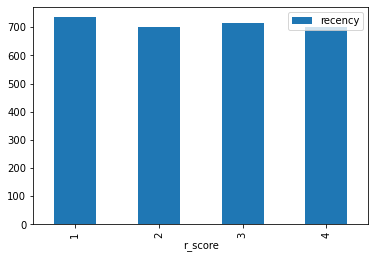

In [29]:
addr_demo_txns.groupby('r_score').agg('recency').count().to_frame().plot(kind='bar')

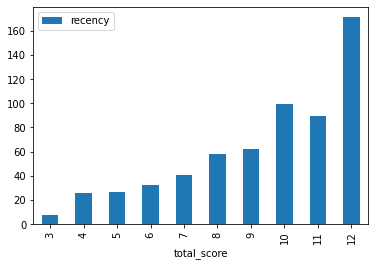

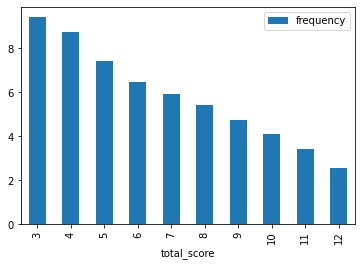

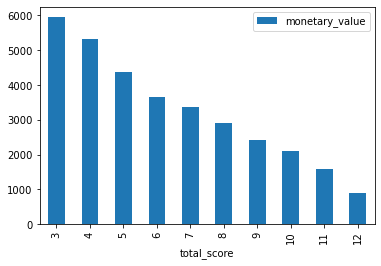

In [30]:
addr_demo_txns.groupby('total_score').agg('recency').mean().to_frame().plot(kind='bar')
addr_demo_txns.groupby('total_score').agg('frequency').mean().to_frame().plot(kind='bar')
addr_demo_txns.groupby('total_score').agg('monetary_value').mean().to_frame().plot(kind='bar')
plt.show()

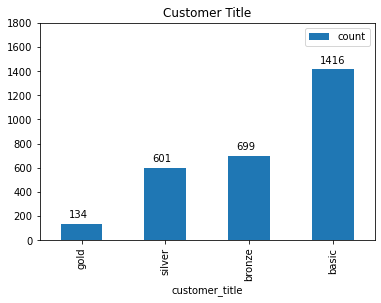

In [31]:
customer_titles_df = addr_demo_txns.groupby('customer_title').agg({
    'rfm_class': lambda x: len(x)
})
customer_titles_df.rename(columns={'rfm_class': 'count'}, inplace=True)
customer_titles_df.sort_values('count').plot(kind='bar')
for i, v in enumerate(customer_titles_df.sort_values('count')['count']):
    plt.text(i - .15, v + 50, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1800])
plt.title('Customer Title')
plt.show()

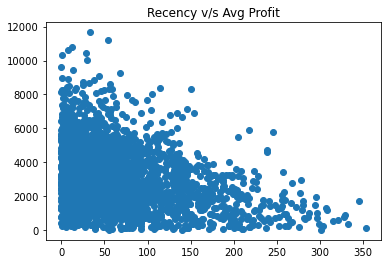

In [32]:
plt.scatter(addr_demo_txns['recency'], addr_demo_txns['monetary_value'])
plt.title('Recency v/s Avg Profit')
plt.show()

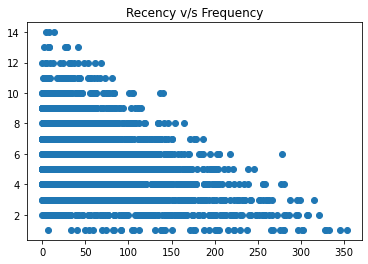

In [33]:
plt.scatter(addr_demo_txns['recency'], addr_demo_txns['frequency'])
plt.title('Recency v/s Frequency')
plt.show()

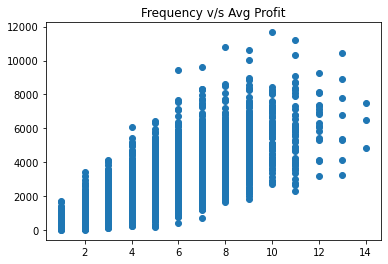

In [34]:
plt.scatter(addr_demo_txns['frequency'], addr_demo_txns['monetary_value'])
plt.title('Frequency v/s Avg Profit')
plt.show()

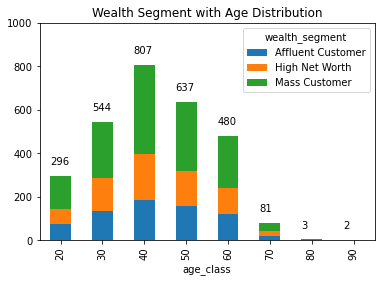

In [35]:
addr_demo_txns.groupby('age_class')['wealth_segment'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(addr_demo_txns.groupby('age_class') \
                      .agg({'wealth_segment': lambda x: len(x)})['wealth_segment']):
    plt.text(i - .25, v + 50, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1000])
plt.title('Wealth Segment with Age Distribution')
plt.show()

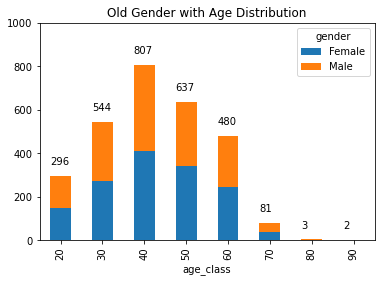

In [36]:
addr_demo_txns.groupby('age_class')['gender'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(addr_demo_txns.groupby('age_class') \
                      .agg({'gender': lambda x: len(x)})['gender']):
    plt.text(i - .25, v + 50, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1000])
plt.title('Old Gender with Age Distribution')
plt.show()

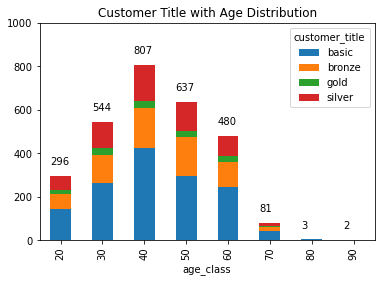

In [37]:
addr_demo_txns.groupby('age_class')['customer_title'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(addr_demo_txns.groupby('age_class') \
                      .agg({'customer_title': lambda x: len(x)})['customer_title']):
    plt.text(i - .25, v + 50, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1000])
plt.title('Customer Title with Age Distribution')
plt.show()

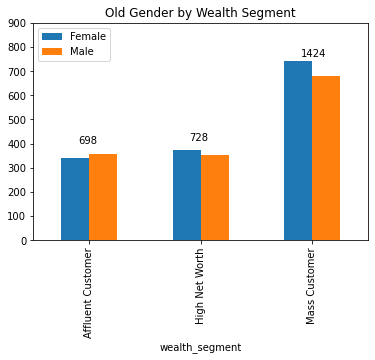

In [38]:
addr_demo_txns.groupby('wealth_segment')['gender'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=False)
for i, v in enumerate(addr_demo_txns.groupby('wealth_segment') \
                      .agg({'gender': lambda x: len(x)})['gender']):
    plt.text(i - .1, v // 2 + 50, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 900])
plt.title('Old Gender by Wealth Segment')
plt.legend(['Female', 'Male'], loc='upper left')
plt.show()

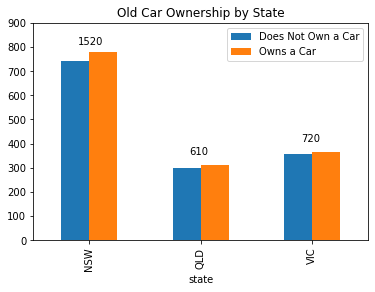

In [39]:
addr_demo_txns.groupby('state')['owns_car'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=False)
for i, v in enumerate(addr_demo_txns.groupby('state') \
                      .agg({'owns_car': lambda x: len(x)})['owns_car']):
    plt.text(i - .1, v // 2 + 50, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 900])
plt.title('Old Car Ownership by State')
plt.legend(['Does Not Own a Car', 'Owns a Car'], loc='upper right')
plt.show()

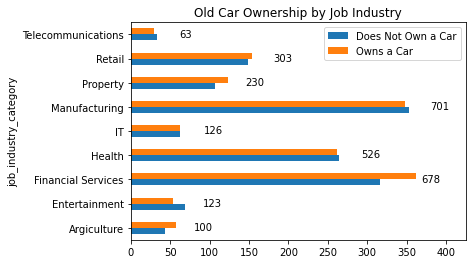

In [40]:
addr_demo_txns.groupby('job_industry_category')['owns_car'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.barh(stacked=False)
for i, v in enumerate(addr_demo_txns.groupby('job_industry_category') \
                      .agg({'owns_car': lambda x: len(x)})['owns_car']):
    plt.text(v // 2 + 30, i - .1, int(v), color='black')
axes = plt.gca()
axes.set_xlim([0,425])
plt.title('Old Car Ownership by Job Industry')
plt.legend(['Does Not Own a Car', 'Owns a Car'], loc='upper right')
plt.show()

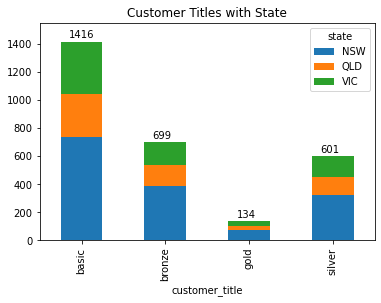

In [41]:
addr_demo_txns.groupby('customer_title')['state'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(addr_demo_txns.groupby('customer_title') \
                      .agg({'state': lambda x: len(x)})['state']):
    plt.text(i - .15, v + 25, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1550])
plt.title('Customer Titles with State')
plt.show()

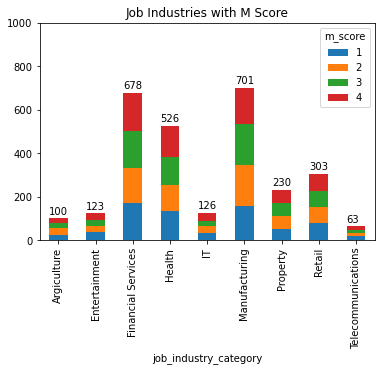

In [42]:
addr_demo_txns.groupby('job_industry_category')['m_score'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(addr_demo_txns.groupby('job_industry_category') \
                      .agg({'m_score': lambda x: len(x)})['m_score']):
    plt.text(i - .25, v + 20, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1000])
plt.title('Job Industries with M Score')
plt.show()

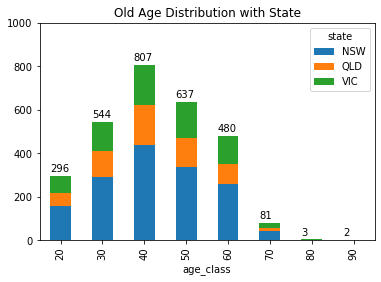

In [43]:
addr_demo_txns.groupby('age_class')['state'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(addr_demo_txns.groupby('age_class').agg({'age': lambda x: len(x)})['age']):
    plt.text(i - .25, v + 20, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 1000])
plt.title('Old Age Distribution with State')
plt.show()

In [44]:
c = addr_demo_txns.groupby(['gender'])['past_3_years_bike_related_purchases'].sum().rename('count').to_frame()
c

,count
gender,
Female,69844
Male,69516


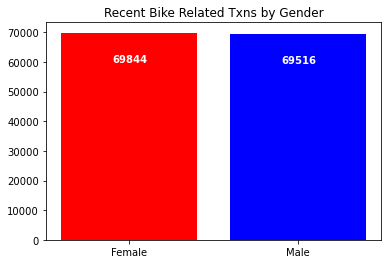

In [45]:
labels = ['Female', 'Male']
plt.bar(labels, c['count'], color=['red','blue'])
for i, v in enumerate(c['count']):
    plt.text(i - .1, v - 10e3, v, color='white', fontweight='bold')
plt.title('Recent Bike Related Txns by Gender')
plt.show()

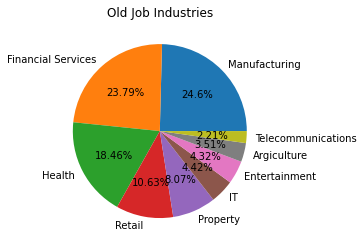

In [46]:
addr_demo_txns.job_industry_category.value_counts().plot.pie(autopct=lambda pct: str(round(pct, 2)) + '%')
plt.title('Old Job Industries')
plt.ylabel('')
plt.show()

In [47]:
c = addr_demo_txns.groupby('customer_title').agg({'age': lambda x: len(x)})
c.rename(columns={'age':'count'},inplace=True)
c['count'] = c['count'].astype(int)
c

,count
customer_title,
basic,1416
bronze,699
gold,134
silver,601


In [48]:
c = addr_demo_txns.groupby(['state','customer_title']).agg({'age': lambda x: len(x)})
c.rename(columns={'age':'count'},inplace=True)
c['count'] = c['count'].astype(int)
c

count
state customer_title       
NSW   basic             738
      bronze            389
      gold               70
      silver            323
QLD   basic             305
      bronze            146
      gold               33
      silver            126
VIC   basic             373
      bronze            164
      gold               31
      silver            152

In [49]:
c = addr_demo_txns.groupby(['total_score']).agg({'age': lambda x: x.count()}).cumsum()
c.rename(columns={'age':'count'},inplace=True)
c['count'] = c['count'].astype(int)
c

,count
total_score,
3,134
4,296
5,558
6,891
7,1300
8,1712
9,2110
10,2417
11,2595


In [50]:
new_cust_list = pd.read_excel(file_name, header=1, sheet_name='NewCustomerList')
new_cust_list.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


In [51]:
new_cust_list.isna().sum()

first_name                               0
last_name                               29
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     17
job_title                              106
job_industry_category                  165
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                   0
address                                  0
postcode                                 0
state                                    0
country                                  0
property_valuation                       0
Unnamed: 16                              0
Unnamed: 17                              0
Unnamed: 18                              0
Unnamed: 19                              0
Unnamed: 20                              0
Rank                                     0
Value                                    0
dtype: int6

In [52]:
new_cust_list.duplicated().sum()

0

In [53]:
new_cust_list.shape

(1000, 23)

In [54]:
new_cust_list_clean = new_cust_list.dropna()
new_cust_list_clean

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.875000,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.112500,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.010000,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.087500,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.650000,0.650000,4,4,1.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ferdinand,Romanetti,Male,60,1959-10-07,Paralegal,Financial Services,Affluent Customer,N,No,...,NSW,Australia,7,0.79,0.7900,0.790000,0.790000,996,996,0.374000
996,Burk,Wortley,Male,22,2001-10-17,Senior Sales Associate,Health,Mass Customer,N,No,...,NSW,Australia,10,0.76,0.7600,0.950000,0.807500,997,997,0.357000
997,Melloney,Temby,Female,17,1954-10-05,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,N,Yes,...,QLD,Australia,2,0.85,1.0625,1.062500,1.062500,997,997,0.357000
998,Dickie,Cubbini,Male,30,1952-12-17,Financial Advisor,Financial Services,Mass Customer,N,Yes,...,QLD,Australia,2,1.09,1.3625,1.362500,1.158125,997,997,0.357000


In [55]:
new_cust_list_clean['age'] = (dt.datetime.now() - new_cust_list_clean['DOB']) / np.timedelta64(1, 'Y')
new_cust_list_clean['age_class'] = ((round(new_cust_list_clean['age'] / 10)) * 10).astype(int)
new_cust_list_clean.head()

<ipython-input-55-7e594cdcb531>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cust_list_clean['age'] = (dt.datetime.now() - new_cust_list_clean['DOB']) / np.timedelta64(1, 'Y')
<ipython-input-55-7e594cdcb531>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cust_list_clean['age_class'] = ((round(new_cust_list_clean['age'] / 10)) * 10).astype(int)


,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,age,age_class
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750,63.130658,60
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750,50.437721,50
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750,46.002312,50
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125,41.583330,40
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125,54.936102,50


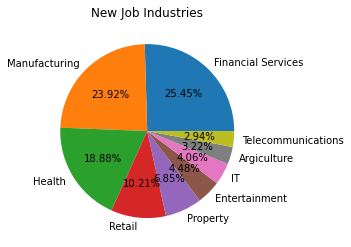

In [56]:
new_cust_list_clean.job_industry_category.value_counts().plot.pie(autopct=lambda pct: str(round(pct, 2)) + '%')
plt.title('New Job Industries')
plt.ylabel('')
plt.show()

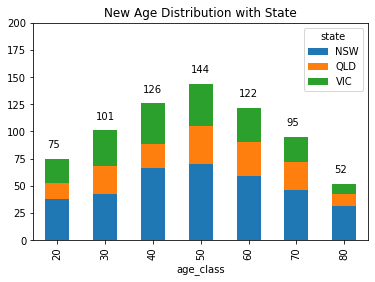

In [57]:
new_cust_list_clean.groupby('age_class')['state'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(new_cust_list_clean.groupby('age_class').agg({'age': lambda x: len(x)})['age']):
    plt.text(i - .2, v + 10, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 200])
plt.title('New Age Distribution with State')
plt.show()

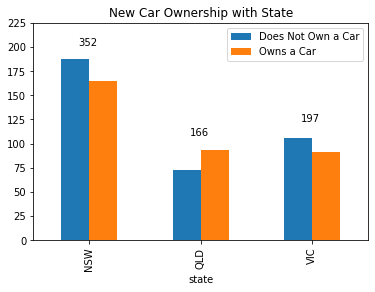

In [58]:
new_cust_list_clean.groupby('state')['owns_car'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=False)
for i, v in enumerate(new_cust_list_clean.groupby('state').agg({'owns_car': lambda x: len(x)})['owns_car']):
    plt.text(i - .1, v // 2 + 25, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 225])
plt.title('New Car Ownership with State')
plt.legend(['Does Not Own a Car', 'Owns a Car'])
plt.show()

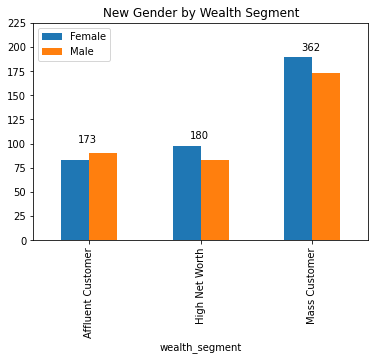

In [59]:
new_cust_list_clean.groupby('wealth_segment')['gender'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=False)
for i, v in enumerate(new_cust_list_clean.groupby('wealth_segment') \
                      .agg({'gender': lambda x: len(x)})['gender']):
    plt.text(i - .1, v // 2 + 15, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 225])
plt.title('New Gender by Wealth Segment')
plt.legend(['Female', 'Male'], loc='upper left')
plt.show()

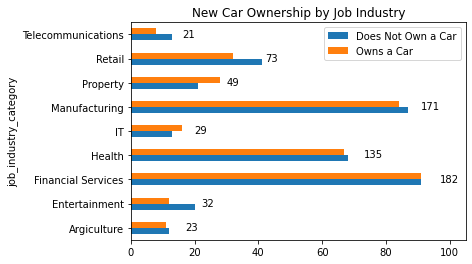

In [60]:
new_cust_list_clean.groupby('job_industry_category')['owns_car'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.barh(stacked=False)
for i, v in enumerate(new_cust_list_clean.groupby('job_industry_category') \
                      .agg({'owns_car': lambda x: len(x)})['owns_car']):
    plt.text(v // 2 + 6, i - .1, int(v), color='black')
axes = plt.gca()
axes.set_xlim([0,105])
plt.title('New Car Ownership by Job Industry')
plt.legend(['Does Not Own a Car', 'Owns a Car'], loc='upper right')
plt.show()

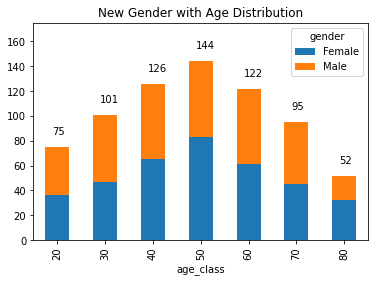

In [61]:
new_cust_list_clean.groupby('age_class')['gender'] \
    .value_counts() \
    .unstack(level=1) \
    .plot.bar(stacked=True)
for i, v in enumerate(new_cust_list_clean.groupby('age_class') \
                      .agg({'gender': lambda x: len(x)})['gender']):
    plt.text(i - .1, v + 10, int(v), color='black')
axes = plt.gca()
axes.set_ylim([0, 175])
plt.title('New Gender with Age Distribution')
plt.show()